# Day 3 Machine Learning
Steps to take:
- Create new category columns
- Encode categorical and ordinal features, (OHE)
- Scale the Dataset
- Feature Engineering
- Fix class imbalance weight, statistics
- 
- Split data into train/test set# Work–Life Stress Score
df_cleaned['WorkLifeStress'] = (df_cleaned['OverTime'] + (df_cleaned['DistanceFromHome'] / 
                                                            df_cleaned['DistanceFromHome'].max()) + (5 - df_cleaned['WorkLifeBalance']))   
- Select and train models
- Discuss results

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
df= pd.read_csv(r"C:\Users\house\Downloads\HR-Employee-Attrition.csv")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler


## Preprocessing

In [52]:
# Drop uneccessary columns
drop_cols = ['EmployeeNumber','EmployeeCount','Over18','StandardHours'] #Columns are either constant or identifying integer

df_cleaned = df.drop(columns=drop_cols)


In [54]:
# encode Yes/No Bolean Columns into binary
binary_cols = ['OverTime', 'Attrition']

for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'Yes': 1, 'No': 0})


In [56]:
df_cleaned['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})  #use binary encoding because only two variables


In [58]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   int64 
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

We can see here that the ordinal columns:
- Education,
- EnvironmentSatisfaction,
- JobInvolvement,
- JobSatisfaction,
- PerformanceRating,
- RelationshipSatisfaction,
- StockOptionLevel,
- WorkLifeBalance 

are all integers and hence don't need any preprocessing for type errors.

Now we must deal with any remaining objects.

In [60]:
nominal_cols = ['BusinessTravel', 'Department','EducationField', 'JobRole','MaritalStatus']
# One Hot encoding on nominal categories
df_cleaned = pd.get_dummies(
    df_cleaned,
    columns=nominal_cols,
    drop_first=True #even though the relationship isn't likely linear, we are still going to drop_first, just to create a robust ML model. 
    #One could equally argue that it isn't necessary in this case. 
).astype(int) 


In [62]:
df_cleaned.head() # double check no true/false values

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,2,0,94,3,2,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,3,1,61,2,2,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
# as long as the rating scale is properly interpreted, we can leave it numerical as one column and not one hot encode it.

## Feature Engineering for Employee Attrition

In [64]:
# -------------------------------------------------------------------
# Feature engineering is done on raw numeric values first to preserve
# meaningful relationships and logic (e.g., WorkLifeStress uses
# 5 - WorkLifeBalance to reverse the scale). 
# After creating all engineered features, we will scale them
# for model consistency and comparability. 
# This order ensures that composite features are correct while
# maintaining reproducibility.
# -------------------------------------------------------------------

# Work–Life Stress Score
df_cleaned['WorkLifeStress'] = (df_cleaned['OverTime'] + (df_cleaned['DistanceFromHome'] / 
                                                            df_cleaned['DistanceFromHome'].max()) + (5 - df_cleaned['WorkLifeBalance']))   
# reverse scale: higher = more stress

# Career Speed
df_cleaned['CareerSpeed'] = df_cleaned['YearsAtCompany'] / df_cleaned['Age']

# Income per Experience
df_cleaned['IncomePerExperience'] = (df_cleaned['MonthlyIncome'] * 12) / (df_cleaned['TotalWorkingYears'] + 1)

#Role stability
df_cleaned['RoleStability'] = df_cleaned['YearsInCurrentRole'] / df_cleaned['YearsAtCompany']

#Compensation per Role
df_cleaned['CompensationPerRole'] = df_cleaned['MonthlyIncome'] / df_cleaned['JobLevel']

#Reward_vs_Happiness
df_cleaned['RewardvsHappiness']= df_cleaned['IncomePerExperience'] * df_cleaned['JobSatisfaction']

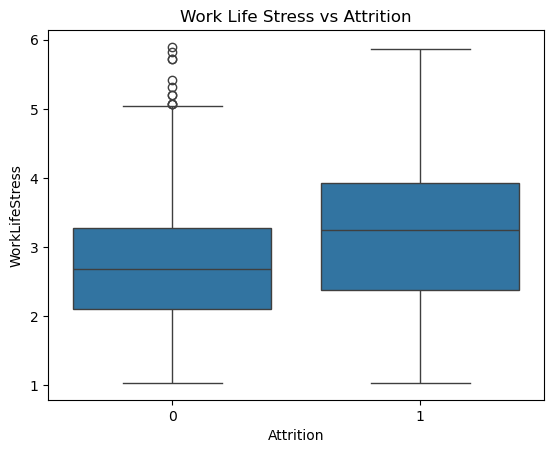

In [66]:
# Exploratory visual check for engineered features
sns.boxplot(x='Attrition', y='WorkLifeStress', data=df_cleaned)
plt.title("Work Life Stress vs Attrition")
plt.show()

**Feature Engineering**

To enhance predictive power for attrition modeling, seven composite features were derived from existing numeric and ordinal inputs. These features were designed to capture distinct aspects of employee behavior, work conditions, career progression, and compensation, while maintaining interpretability and reproducibility:

- Work–Life Stress Score: Combines overtime, commute distance, and work-life balance to quantify overall stress levels.

- Career Speed: Ratio of years at company to age, reflecting career progression relative to life stage.

- Income per Experience: Annual income normalized by total working years, indicating compensation relative to experience.

- Role Stability: Years in current role relative to total tenure, capturing consistency versus frequent role changes.

- Compensation per Role: Monthly income adjusted for job level, representing relative reward for role responsibility.

- Reward vs Happiness: Interaction of compensation relative to experience and job satisfaction, highlighting potential misalignment between pay and employee satisfaction.

All features are numeric and derived from preprocessed inputs to ensure consistency. This set provides a concise yet informative feature space, minimizing noise while maximizing predictive signal.


## Machine Learning

In [107]:
# ----------------------------
# Scaling, Train/Test Split, and Decision Tree Training
# ----------------------------

# Define target and features
target = 'Attrition'
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

# List of numeric columns (including engineered features)
numeric_cols = [
    'Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears',
    'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
    'YearsWithCurrManager', 'DailyRate', 'HourlyRate', 'MonthlyRate',
    'NumCompaniesWorked', 'TrainingTimesLastYear', 'PercentSalaryHike', 
    'WorkLifeStress', 'CareerSpeed','IncomePerExperience','RoleStability',
    'CompensationPerRole','RewardvsHappiness'
]

# Scale numeric features
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y
)

# Initialize Decision Tree and train
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=32)

dt_model.fit(X_train, y_train)

#predict
y_pred = dt_model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       247
           1       0.33      0.30      0.31        47

    accuracy                           0.79       294
   macro avg       0.60      0.59      0.60       294
weighted avg       0.78      0.79      0.79       294



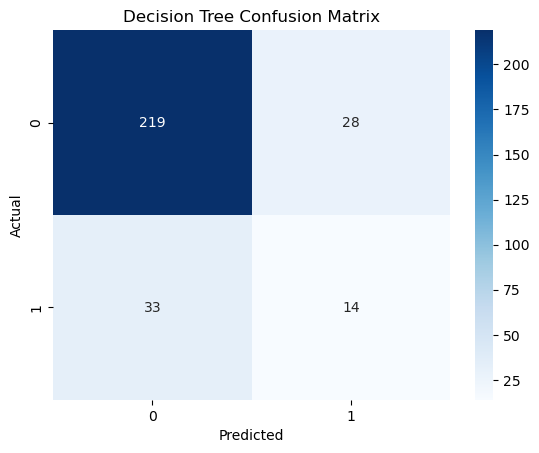

In [109]:
# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

High accuracy (79%) but only 30% recall means it isn't predicting who is leaving the company, just generally predicting that they don't. Another run of the decision tree is needed with a few tweaks to see if it can predict attrition better. 

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85       247
           1       0.34      0.53      0.42        47

    accuracy                           0.76       294
   macro avg       0.62      0.67      0.63       294
weighted avg       0.81      0.76      0.78       294



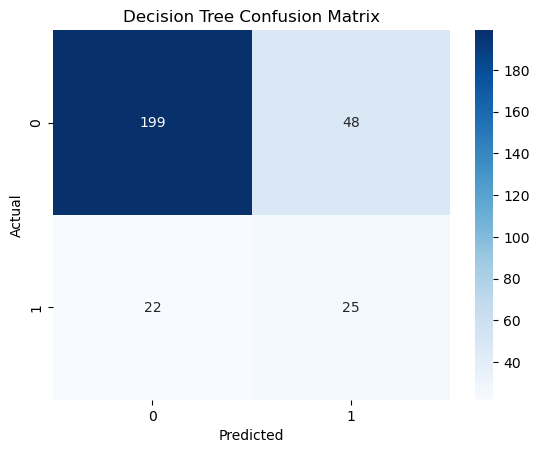

In [111]:
# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=32, max_depth =5, min_samples_leaf=10)
    
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The results here are slightly less accurate but with a better prediction for attrition, 53%. 
At the moment I will create a Pipeline to find the **best fit for the parameters**. Then test 3 types of models: linear (most likely a poor fit), decision tree, and random forest. Although I can delete the previous cells and proceed directly to the pipeline, as a learner, I will document my thought process for the time being. I will not delete my minmax scaling, but would in future save it for the pipeline steps. 

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Pipeline
pipe = Pipeline([
    ('dt', DecisionTreeClassifier(
        class_weight='balanced',
        random_state=32
    ))
])

# Hyperparameter grid
param_grid = {
    'dt__max_depth': [3, 5, 7, 10, None],
    'dt__min_samples_leaf': [5, 10, 20],
    'dt__min_samples_split': [2, 5, 10]
}

# Grid search
grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring='f1',         
    cv=5,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Results
print("Best Model:", grid_search.best_estimator_)
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Best Model: Pipeline(steps=[('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                                        min_samples_leaf=10,
                                        random_state=32))])
Best Params: {'dt__max_depth': 3, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}
Best CV Score: 0.44263430869995213


In [116]:
best_dt = grid_search.best_estimator_

y_pred_dt = best_dt.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       247
           1       0.34      0.53      0.42        47

    accuracy                           0.76       294
   macro avg       0.62      0.67      0.63       294
weighted avg       0.81      0.76      0.78       294



Looking at these results it matches up fairly well to the best version of our decision tree before the pipeline. Our accuracy is stronger at 76, but our recall remains the same. The F1 scores however are improved. Now we proceed to Logistic regression model, which will be unlikely to exceed this score. 

In [124]:


# pipe_lr = Pipeline([
#     ('lr', LogisticRegression(
#         class_weight='balanced',
#         max_iter=1000,
#         random_state=32
#     ))
# ])

# param_grid_lr = {
#     'lr__C': [0.01, 0.1, 1, 10],
#     'lr__penalty': ['l1', 'l2'],
#     'lr__solver': ['liblinear']  
# }

# grid_search_lr = GridSearchCV(
#     pipe_lr,
#     param_grid_lr,
#     scoring='f1',
#     cv=5,
#     n_jobs=-1
# )

# grid_search_lr.fit(X_train, y_train)

# print("Best Logistic Model:", grid_search_lr.best_estimator_)
# print("Best Params:", grid_search_lr.best_params_)
# print("Best CV Score:", grid_search_lr.best_score_)


In [120]:
print(X_train.isna().sum().sort_values(ascending=False).head())
np.isinf(X_train).sum()

RoleStability                        37
Age                                   0
JobRole_Manufacturing Director        0
Department_Research & Development     0
Department_Sales                      0
dtype: int64


Age                                  0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EnvironmentSatisfaction              0
Gender                               0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
OverTime                             0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       0
YearsInCurrentRole                   0
YearsSinceLastPromotion              0
YearsWithCurrManager                 0
BusinessTravel_Travel_Fre

I could very easily delete these cells and showcase only the fixed issues. However this was a learning experience. Two especially engineered columns have NaN values (most likely dividing by 0) that won't work with linear models. we will fill them in and run the pipeline again.
In future these Nans could be addressed prior to ML stage.


In [122]:
df_cleaned[['RoleStability','CareerSpeed']] = df_cleaned[['RoleStability', 'CareerSpeed']].fillna(0)


In [126]:

target = 'Attrition'
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y #to preserve class balance
)
pipe_lr = Pipeline([
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=32
    ))
])

param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear']  
}

grid_search_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

print("Best Logistic Model:", grid_search_lr.best_estimator_)
print("Best Params:", grid_search_lr.best_params_)
print("Best CV Score:", grid_search_lr.best_score_)

Best Logistic Model: Pipeline(steps=[('lr',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=32,
                                    solver='liblinear'))])
Best Params: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Best CV Score: 0.5100094438996041


In [128]:
best_lr = grid_search_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.93      0.76      0.83       247
           1       0.35      0.68      0.46        47

    accuracy                           0.74       294
   macro avg       0.64      0.72      0.65       294
weighted avg       0.83      0.74      0.77       294



Unexpectedly the LogisticRegression model did quite well in predicting Employees who left, at 68%. Much better than the DecisionTree model with 53%, although it's overall F1 score is in fact slightly lower. 
As a last comparison we'll run RandomForest through the pipeline to see what it can predict. 

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        random_state=32,
        n_jobs=-1
    ))
])

# Hyperparameter grid
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 5, 10]
}

# Grid search
grid_search_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit
grid_search_rf.fit(X_train, y_train)

# Results
print("Best Random Forest Model:", grid_search_rf.best_estimator_)
print("Best Params:", grid_search_rf.best_params_)
print("Best CV Score:", grid_search_rf.best_score_)


Best Random Forest Model: Pipeline(steps=[('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=10, n_estimators=200,
                                        n_jobs=-1, random_state=32))])
Best Params: {'rf__max_depth': 5, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best CV Score: 0.4967061942671699


In [135]:

y_pred_rf = grid_search_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       247
           1       0.44      0.55      0.49        47

    accuracy                           0.82       294
   macro avg       0.68      0.71      0.69       294
weighted avg       0.84      0.82      0.82       294



F1 score here has the highest at 82% Recall however is only 55. 

In [138]:


models_results = []

def add_results(model_name, y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    models_results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Attrition)": report["1"]["precision"],
        "Recall (Attrition)": report["1"]["recall"],
        "F1 (Attrition)": report["1"]["f1-score"]
    })

add_results("Decision Tree", y_test, y_pred_dt)
add_results("Logistic Regression", y_test, y_pred_lr)
add_results("Random Forest", y_test, y_pred_rf)

results_df = pd.DataFrame(models_results)
results_df


,Model,Accuracy,Precision (Attrition),Recall (Attrition),F1 (Attrition)
0,Decision Tree,0.751701,0.341463,0.595745,0.434109
1,Logistic Regression,0.744898,0.347826,0.680851,0.460432
2,Random Forest,0.816327,0.440678,0.553191,0.490566


Based on the results, Random Forest outperforms the other two models across most metrics. Logistic Regression better predicts those who leave,  attrition (68%), but at a slight cost to overall accuracy. The Decision Tree, in contrast, performs worse across nearly all metrics, with lower precision and F1 scores, making it the least effective model for predicting attrition. Random Forest, on the other hand, has the highest precision for attrition (44%), making it the strongest model overall for predicting attrition. We can further take a look at what features play a role in predictions, as well as visualize a correlation map of all columns.

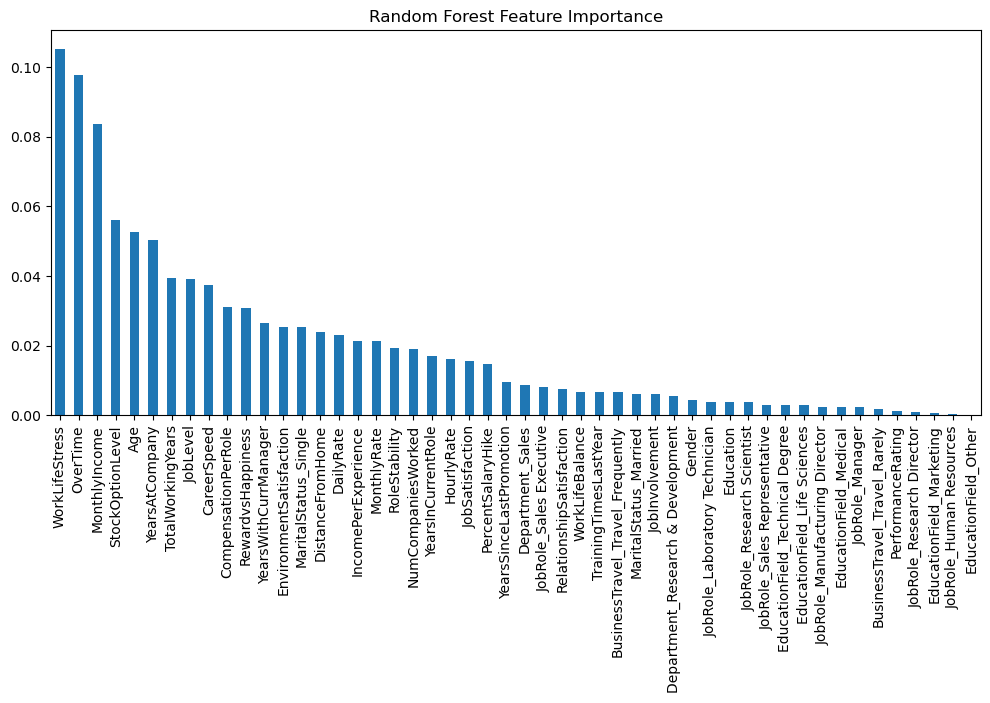

In [141]:

rf_best = grid_search_rf.best_estimator_.named_steps['rf']

feat_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.title("Random Forest Feature Importance")
plt.show()

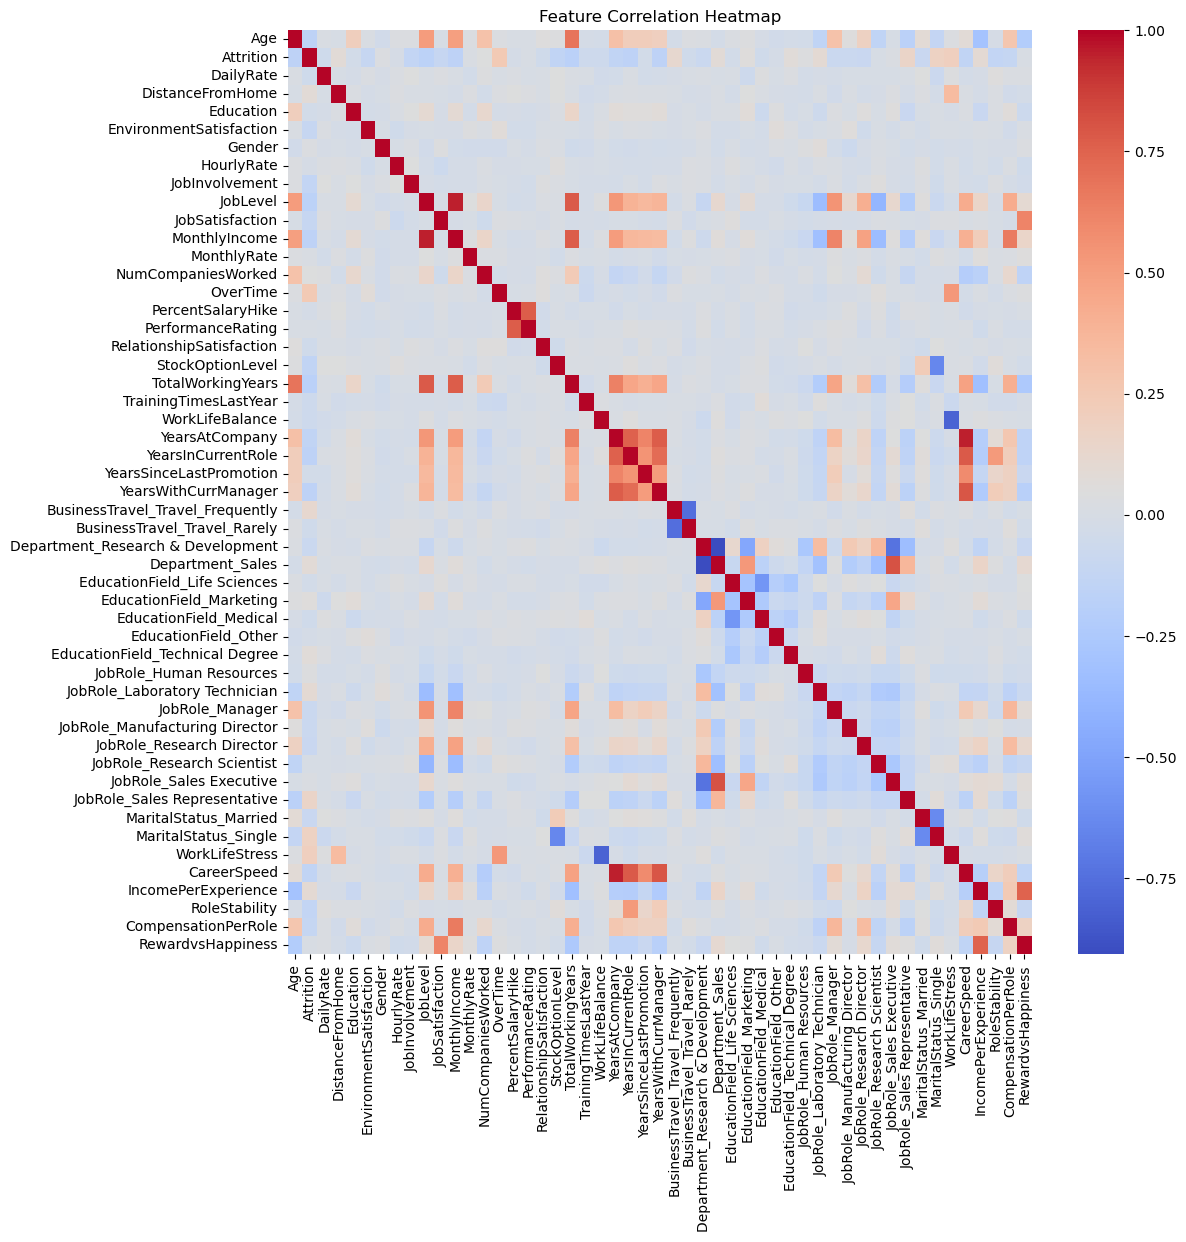

In [143]:
# Compute correlation matrix
corr_matrix = df_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()


## Key Takeaways 
### Model Comparison
We trained three models to predict employee attrition: Decision Tree, Logistic Regression, and Random Forest.
First we did it without Pipeline, then used the pipeline to find the best parameters for our Decision Tree Model, as well as the other two.
This gave us three fairly strong results. (Accuracy rates all above 70%)
- Random Forest achieved the highest overall accuracy (0.81) and weighted F1 (0.82).
- Logistic Regression maintains strong recall for the minority class but lower precision.
- Decision Tree provides interpretability but is slightly weaker overall.

Random Forest is the preferred model for predicting attrition due to its balance of accuracy and predictive power.

### Feature Importance 
The Random Forest model identified the following top features:
- WorkLifeStress – employees under higher stress are more likely to leave.
- OverTime – extended overtime correlates with higher attrition.
- Monthly Income – low compensation drives attrition.

### Correlation Heatmap
Since this wasn't just keyed into the RandomForest model, we had some similarities and differences. One finding was a correlation with *OverTime* as we observed in the EDA stage. *WorkLifeStress* was also correlated. But *MonthlyIncome* was not at all correlated. *Maritial Status-Single* was though, as well as being a *Sales Representative* and *travelling frequently*. 

### Takeaways.
- Engineered features such as Work–Life Stress, and even to an extent, Career Speed, are effective predictors.
- Random Forest provides the best predictive performance and interpretable feature rankings.

## Actionables
Employees with high Work–Life Stress scores and frequent overtime are significantly more likely to leave. Reducing overtime or providing workload support may help lower attrition risk.

Income per Experience emerged as a predictor, suggesting that misalignment between experience and income could cause disatisfaction. HR interventions should focus on both pay equity and employee engagement.

Certain job roles and frequent business travel show higher attrition risk. Targeted retention strategies for these groups could be more effective than company-wide policies.

### Next Steps & Recommendations

To further improve predictive performance, class imbalance could be addressed more aggressively using techniques such as SMOTE or undersampling. Exploring more advanced models like XGBoost or LightGBM may also boost results. Enhancing interpretability through feature importance or similar techniques can help translate model insights into actionable HR interventions, allowing HR to understand which factors influence employee attrition and  take targeted actions to prevent it.